In [397]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [398]:
import yaml
import pandas as pd

from utils.data import *
from algorithms import load_model

In [399]:
fore_date = pd.to_datetime('2020-11-02')
n_fore = 14
start_date = fore_date + pd.Timedelta(days=1)
end_date = fore_date + pd.Timedelta(days=n_fore)

In [413]:
with open('./experiments/lightgbm1.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.Loader)
config["data"]

{'ips_file': './data/OxCGRT_latest.csv',
 'nb_lookback_days': 1,
 'y': 'AccCasesRM'}

In [414]:
%%time 
data = Data(config)

/home/schapke/miniconda2/envs/xprize/lib/python3.7/site-packages/IPython/core/magic.py:188: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  call = lambda f, *a, **k: f(*a, **k)


Warning! Interpolating missing ConfirmedCases statistics. (This will affect the ground truth labels NewCases).
CPU times: user 2.74 s, sys: 35 ms, total: 2.77 s
Wall time: 2.77 s


In [415]:
model = load_model(config)

In [419]:
%%time
n_fore = 15
fore_date = pd.to_datetime("2020-10-01")
iterable = data.build_test_iter(fore_date, n_fore)

sample = iterable()
for i in range(n_fore): 
    sample = iterable(model.predict(sample))
print("done!")

acc: GeoID
Afghanistan__nan     1.633439
Albania__nan        -0.275070
Algeria__nan        -4.525795
Andorra__nan        -1.886838
Angola__nan         10.001031
dtype: float64 prediction: [-1.23026453 -1.33087235 -6.23653639  1.43665446  3.52558388] prev vel: GeoID
Afghanistan__nan     28.285714
Albania__nan        130.928571
Algeria__nan        183.142857
Andorra__nan         43.714286
Angola__nan         100.214286
                       ...    
Venezuela__nan      836.142857
Vietnam__nan          2.214286
Yemen__nan            1.071429
Zambia__nan          62.285714
Zimbabwe__nan        17.142857
Name: NewCasesRM, Length: 265, dtype: float64 vel:, GeoID
Afghanistan__nan     29.919154
Albania__nan        130.653501
Algeria__nan        178.617062
Andorra__nan         41.827448
Angola__nan         110.215317
                       ...    
Venezuela__nan      824.551905
Vietnam__nan          2.113345
Yemen__nan            0.418967
Zambia__nan          63.175398
Zimbabwe__nan        17.9

In [375]:
forecasts = iterable()
regions = sample.index
fore_dates = pd.date_range(fore_date, periods=n_fore, freq='1d')
labels = data.df.loc[fore_dates].NewCasesRM.unstack(level=0)

In [376]:
mae = (labels - forecasts).values.mean()
maes = (labels - forecasts).values.mean(1)
mae

67.97820824446681

In [394]:
#i = 218
#i = maes.argmax()
i = maes.argsort()[-17]
region = regions[i]
series = data.df.reorder_levels([1,0]).loc[region] 

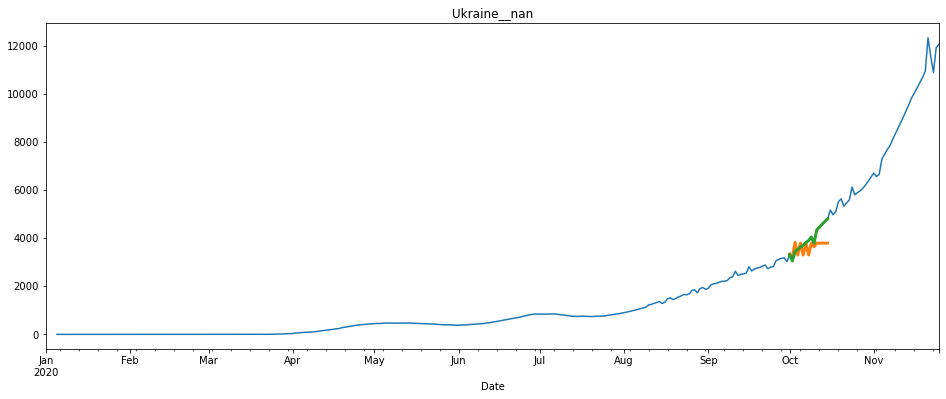

In [395]:
ax = series.NewCasesRM.plot(figsize=(16, 6), title=region)
ax = forecasts.loc[region].plot(ax=ax, linewidth=3)
ax = series.loc[fore_dates].NewCasesRM.plot(ax=ax, linewidth=3)

# ######################################
# Global Average

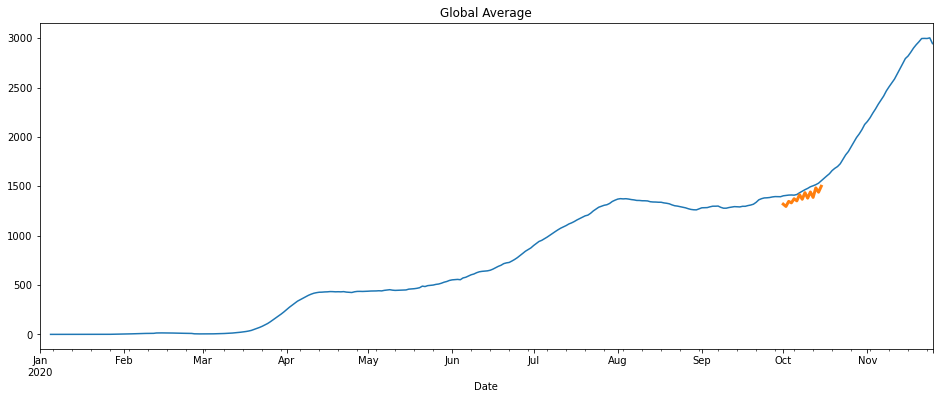

In [396]:
ax = data.df.reset_index().groupby("Date").mean().NewCasesRM.plot(figsize=(16, 6), title="Global Average")
ax = forecasts.mean(0).plot(ax=ax, linewidth=3)